# Portfolio assignment week 5

## 1. SVC

The Scikit-learn library provides different kernels for the Support Vector Classifier, e.g. `RBF` or `polynomial`.

Based on the examples [in the accompanying notebook](../Exercises/E_LR_SVM.ipynb), create your own `SVC` class and configure it with different kernels to see if you are able to have it correctly separate the moon-dataset. You can also use a `precomputed` kernel. In addition, there are several parameters you can tune to for better results. Make sure to go through [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

**Hint**:

- Plot the support vectors for understanding how it works.
- Give arguments why a certain kernel behaves a certain way.

## 2. Model Evaluation

Classification metrics are important for measuring the performance of your model. Scikit-learn provides several options such as the `classification_report` and `confusion_matrix` functions. Another helpful option is the `AUC ROC` and `precision-recall curve`. Try to understand what these metrics mean and give arguments why one metric would be more important then others.

For instance, if you have to predict whether a patient has cancer or not, the number of false negatives is probably more important than the number of false positives. This would be different if we were predicting whether a picture contains a cat or a dog – or not: it all depends on the context. Thus, it is important to understand when to use which metric.

For this exercise, you can use your own dataset if that is eligable for supervised classification. Otherwise, you can use the [breast cancer dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset) which you can find on assemblix2019 (`/data/datasets/DS3/`). Go through the data science pipeline as you've done before:

1. Try to understand the dataset globally.
2. Load the data.
3. Exploratory analysis
4. Preprocess data (skewness, normality, etc.)
5. Modeling (cross-validation and training)
6. **Evaluation**

Create and train several `LogisticRegression` and `SVM` models with different values for their hyperparameters. Make use of the model evaluation techniques that have been described during the plenary part to determine the best model for this dataset. Accompany you elaborations with a conclusion, in which you explicitely interpret these evaluation and describe why the different metrics you are using are important or not. Make sure you take the context of this dataset into account.

# Data
for this Assignment I found two great dataset, one of them is [Cancer Dataset](https://www.kaggle.com/datasets/erdemtaha/cancer-data) and the other one is [Star Classification Dataset](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17). I had difficulty deciding between the star dataset, which involves multi-class classification, and the cancer dataset, which is a binary classification problem. However, for this week's assignment, I decided to work on the Cancer Dataset since I worked another physics dataset for second assignment. I may explore the star classification dataset in the future, particularly for unsupervised classification section. 

# Loading Data

In [37]:
# general libraries
import yaml
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering module
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression

In [2]:
#inspired by https://fennaf.gitbook.io/bfvm22prog1/data-processing/configuration-files/yaml

def configReader():
    """
    explanation: This function open config,yaml file 
    and fetch the gonfigue file information
    input: ...
    output: configue file
    """
    with open("config.yaml", "r") as inputFile:
        config = yaml.safe_load(inputFile)
    return config

In [3]:
def dataframe_maker(config):
    file_directory, file_name = config.values()
    os.chdir(file_directory)
    df = pd.read_csv(file_name).drop('Unnamed: 32', axis=1)
    return df
df = dataframe_maker(configReader())
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


This dataset consists of 569 samples with 32 features. In my opinion, during the inspection phase, one of the primary objectives is to become acquainted with various aspects of the dataset. Therefore, I conducted some research on the different features of this dataset and compiled a list of them below. The features primarily covers the following parameters:

**concavity**: This concept pertains to the presence of concave areas on the surface of a tumor. A greater number of concave points along the nuclear border is associated with a higher probability of malignancy. The severity and quantity of these concave points demonstrate a positive correlation with the diagnosis.[<a href="https://rpubs.com/Kevin_Nguyen_Tran/662211" target="_blank">link</a>]

**compactness**: Tumor compactness is defined as the ratio of the tumor's volume to its surface area. This feature is closely tied to the spatial configuration of tumors, and as a result, we can expect to observe some dependencies between tumor compactness and other spatial features. [<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5352371/" target="_blank">link</a>]

**Fractal Dimension**:  Fractal dimension analysis is a computational image processing technique utilized to evaluate the level of complexity within patterns. The technique, described comprehensively in the provided link, demonstrates its effectiveness in enhancing the histopathological diagnosis of breast cancer. [<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8087740/" target="_blank">link</a>] 

**symmetry**: In typical normal tissues, cell division typically produces identical or nearly identical pairs of daughter cells. However, in the context of cancer, cell division often follows an asymmetric pattern, characterized by a series of events that break the symmetry. If you're interested in learning more about this topic, there is an informative article available that provides further insights. [<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5837760/" target="_blank">link</a>]

**smoothness**: Benign masses typically exhibit smooth, round, and well-defined boundaries, in contrast to malignant tumors that often display spiculated, rough, and indistinct edges. Various methods can be employed to quantify tumor smoothness, including the neighboring gray-level dependence matrix (NGLDM) method and the peak-variance method. [<a href="https://pubmed.ncbi.nlm.nih.gov/1623493/" target="_blank">link</a>] [<a href="https://my.clevelandclinic.org/health/diseases/22121-benign-tumor" target="_blank">link</a>]

**radius, area, and perimeter**: The spatial configuration of a tumor plays a crucial role in evaluating its malignancy. A commonly used approach to determine the volume and perimeter of subcutaneous tumors involves measuring the length and width of the tumor using a caliper. This method assumes that the tumor has an ellipsoidal shape and that its height is equal to its width. By applying the formula for the volume and perimeter of an ellipsoid, these measurements can be used to estimate these parameters accurately.[<a href="https://biopticon.com/resources/tumor-volume-measurements-by-calipers/" target="_blank">link</a>]

**cancer texture**: The topic of cancer texture remains a subject of debate within scientific societies. While tumors may appear hard to the touch externally, research has revealed that individual cells within the tissue exhibit non-uniform rigidity and can even display variations in softness throughout the tumor. Texture analysis is employed to quantitatively assess texture characteristics. By examining the spatial variation in pixel intensities, it captures and quantifies intuitive qualities such as roughness, smoothness, silkiness, or bumpiness associated with the tumor's appearance. [<a href="https://cos.northeastern.edu/news/cancer-tumors-arent-always-as-tough-as-they-seem/" target="_blank">link</a>] [<a href="https://www.mathworks.com/help/images/texture-analysis-1.html" target="_blank">link</a>]

# Inspecting Dataset
Similar to all the privious notebooks, I should metioned that this section is one of the most important part of datascience pipeline. Consequently, one should be cautious to find all the abnormaliries and characteristics of a dataset.

In [4]:
def inspecting_data(df):

    # find the shape of data
    print(f'dataset has {df.shape[0]} observations, and {df.shape[1]} variables\n')

    # finding the information of this dataset
    print(f'{df.info()}\n')

    # extract the number of null values of the dataset
    null_values = df.isnull().sum().sum()
    print(f'the total number of null values in this dataset is {null_values}\n')

    # find whether the number of unique ids is equel to the number of observations
    if df.id.unique().shape[0] == df.shape[0]:
        print(f'the number of unique IDs is {df.shape[0]}, which it is equal to the number of observations\n')
    
    # find the distributaion of the datapoints in the label column
    member_numbers = df.diagnosis.value_counts()
    print(f'number of members in each diagnosis category')
    print(f'{member_numbers}\n')
    print(f'Benign (B): {(member_numbers[0] / df.shape[0]).round(3)}%')
    print(f'Malignant (M): {(member_numbers[1] / df.shape[0]).round(3)}%')

In [5]:
inspecting_data(df)

dataset has 569 observations, and 32 variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non

During the data inspection phase, it was observed that the dataset consists of 30 float features, one integer column representing the ID, and a categorical column containing the labels. One of the most important characteristics of this dataset is the presence of data imbalance. Specifically, the benign group constitutes two-thirds of the total datapoints, while the malignant cases represent only one-third of the dataset. however, the classification methods will initially be implemented without addressing this concern, and the subsequent step will involve tackling the data imbalance and re-implementing the classification methods with the appropriate adjustments. With this manner one can see the effect of the data imbalance in the outcome of the classification methods.

Before entering the next step, I found it valuable to compare the mean values of features for these two categories, and find whether there is any different between their mean values.

In [6]:
# this table shows that these two cance categories (M, B) are completely different from each other
df.copy().groupby('diagnosis').mean()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,
B,2.654382e+07,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,...,13.379801,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442
M,3.681805e+07,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,...,21.134811,29.318208,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530


Almost all the malignant tumours' features are greater than Benign tumours, especially when it comes to spatial attributes. It shows that Malignant tumours are in average larger than their benign counterparts. Also, these tumours are more concave and compact. However, there is no clear evidece of any difference in the smoothness of the tumours from these two categories. Based on the table one can see the difeerence between values of different features is evident. To continue, the next step will be preprocessing.

# Preprocessing Data
In this sction I will evaluate the correlation, skewness, and the need for normalizing for features. First, I will evaluate the correlation between features. 

In [19]:
# slice the float features
float_df = df.iloc[:,2:]

# make correlation df
corr_df= float_df.corr()

# Strip out the diagonal values for the next step
for x in range(len(corr_df.columns)):
    corr_df.iloc[x,x] = 0.0

corr_df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,0.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.323782,0.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.997855,0.329533,0.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.987357,0.321086,0.986507,0.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,0.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316


One way to determine the correlation between these columns is using heatmap.

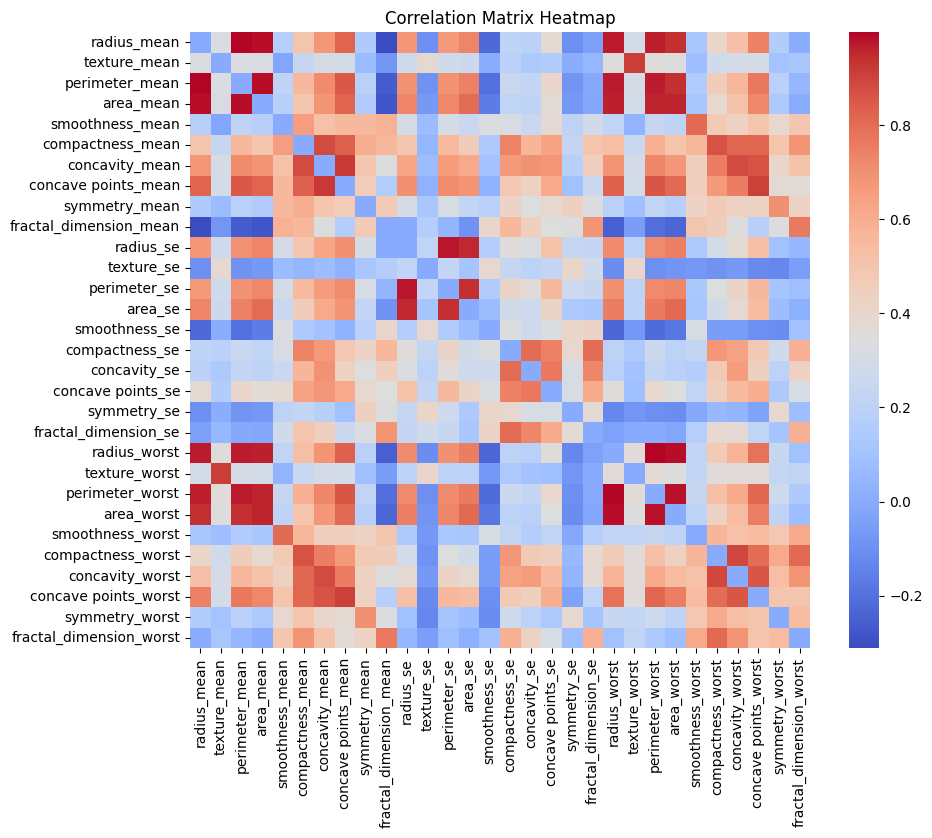

In [22]:
# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap")
plt.show()

Based on the heatmap analysis, it is evident that certain features exhibit strong positive correlations, confirming our initial expectations. Notably, features such as radius, area, and perimeter, regardless of whether they are categorized as mean, se, or worst, demonstrate a high degree of positive correlation. Additionally, concavity, concave points, and compactness exhibit significant positive correlations across all three categories.

Furthermore, one can evaluate which feature is correlated the most with another feature.

In [23]:
corr_df.abs().idxmax()

radius_mean                         perimeter_mean
texture_mean                         texture_worst
perimeter_mean                         radius_mean
area_mean                              radius_mean
smoothness_mean                   smoothness_worst
compactness_mean                    concavity_mean
concavity_mean                 concave points_mean
concave points_mean                 concavity_mean
symmetry_mean                       symmetry_worst
fractal_dimension_mean     fractal_dimension_worst
radius_se                             perimeter_se
texture_se                             symmetry_se
perimeter_se                             radius_se
area_se                                  radius_se
smoothness_se                 fractal_dimension_se
compactness_se                fractal_dimension_se
concavity_se                        compactness_se
concave points_se                     concavity_se
symmetry_se                          symmetry_mean
fractal_dimension_se           

Also, we can find the the magnitude of these maximum correlations.

In [25]:
corr_df.abs().max()

radius_mean                0.997855
texture_mean               0.912045
perimeter_mean             0.997855
area_mean                  0.987357
smoothness_mean            0.805324
compactness_mean           0.883121
concavity_mean             0.921391
concave points_mean        0.921391
symmetry_mean              0.699826
fractal_dimension_mean     0.767297
radius_se                  0.972794
texture_se                 0.411621
perimeter_se               0.972794
area_se                    0.951830
smoothness_se              0.427374
compactness_se             0.803269
concavity_se               0.801268
concave points_se          0.771804
symmetry_se                0.449137
fractal_dimension_se       0.803269
radius_worst               0.993708
texture_worst              0.912045
perimeter_worst            0.993708
area_worst                 0.984015
smoothness_worst           0.805324
compactness_worst          0.892261
concavity_worst            0.892261
concave points_worst       0

As mentioned, the presence of high correlation between certain features can have significant consequences, including:

1. Overfitting: When highly correlated features are included in the model, it can introduce unnecessary complexity, leading to overfitting.

2. Model Instability: Redundant features can cause instability in the model's parameters. It means when that small changes in the training data or feature values can lead to significant changes in the model's predictions.

3. Increased Computational Complexity: Redundant features can increase the complexity and computation time  of the model drastically. 

in this situation there are two ways to deal with this problem.

1. Dimensionality Reduction techniques: These techniques allow for the transformation of the existing features into a smaller set that eliminates redundancies. However, it is important to note that if interpretability of the features is a priority, these methods may not be the ideal choice. Some of these techniques are PCA, FA, and MDS.

2. Feature Selection: These techniques enable the selection of a representative subset of features from the original dataset, effectively reducing redundancy. Unlike the previous technique, this approach preserves the most significant features, thereby maintaining interpretability. Examples of such techniques include SelectKBest and SelectPercentile.

In the following step, I will use feature selection technique specificly SelectKBest since I want to preserve the interpretability of my dataset. But, one can use DR techniques such as PCA.

In [34]:
def sorting_scores(df, fit):
    rank_dict = {}
    names = df.columns

    # make a dictionary of scores
    for number in range(len(fit.scores_)):
        rank_dict[names[number]] = fit.scores_[number]

    # sort the scores
    rank_dict = dict(sorted(rank_dict.items(), key=lambda item: -1 * item[1]))

    return rank_dict

In [35]:
def plotting_score(df, fit):

    # sort scores with a decending manner
    rank_dict = sorting_scores(df, fit)

    keys = list(rank_dict.keys())
    values = list(rank_dict.values())

    # sketch the plot
    fig = plt.figure(figsize= (15,6))
    # Plotting the data
    plt.scatter(keys, values)

    # Optional: Rotate x-axis labels for better readability
    plt.xticks(rotation=90)

    # Optional: Add labels and a title
    plt.xlabel("Sensors")
    plt.ylabel("Scores")
    plt.title("Sensor-Score")

    # Display the plot
    plt.show()

In [28]:
def making_one_hot(df):
    
    # make one hot encoder
    status_series = df.diagnosis
    one_hot = pd.get_dummies(status_series)
    one_hot = one_hot.astype(int)
    return one_hot

In [38]:
def feature_engineering(df, normalization='min_max'):

    float_df = df.iloc[:,2:]
    # make one hot encoder
    one_hot = making_one_hot(df)

    # Normalize the dataset
    if normalization == 'max':
        
        float_df = float_df.apply(lambda x: x / x.abs().max())
    
    elif normalization == 'min_max':
        float_df = float_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    
    # extract feature importance scores
    selector = SelectKBest(score_func=mutual_info_regression)
    fit = selector.fit(float_df, one_hot['M'])
    
    return selector, fit

In [39]:
# run SelectKBest
selector, fit = feature_engineering(df)
fit.scores_

array([0.36645437, 0.09603707, 0.40311035, 0.36014422, 0.07901685,
       0.21341042, 0.37619417, 0.43873526, 0.07151081, 0.00627787,
       0.24611529, 0.        , 0.2720539 , 0.33664864, 0.01795785,
       0.07490007, 0.11437311, 0.12821029, 0.01044683, 0.03377254,
       0.45409633, 0.12376244, 0.47840435, 0.46262416, 0.09698182,
       0.22601011, 0.31114958, 0.43619804, 0.09018095, 0.06669585])

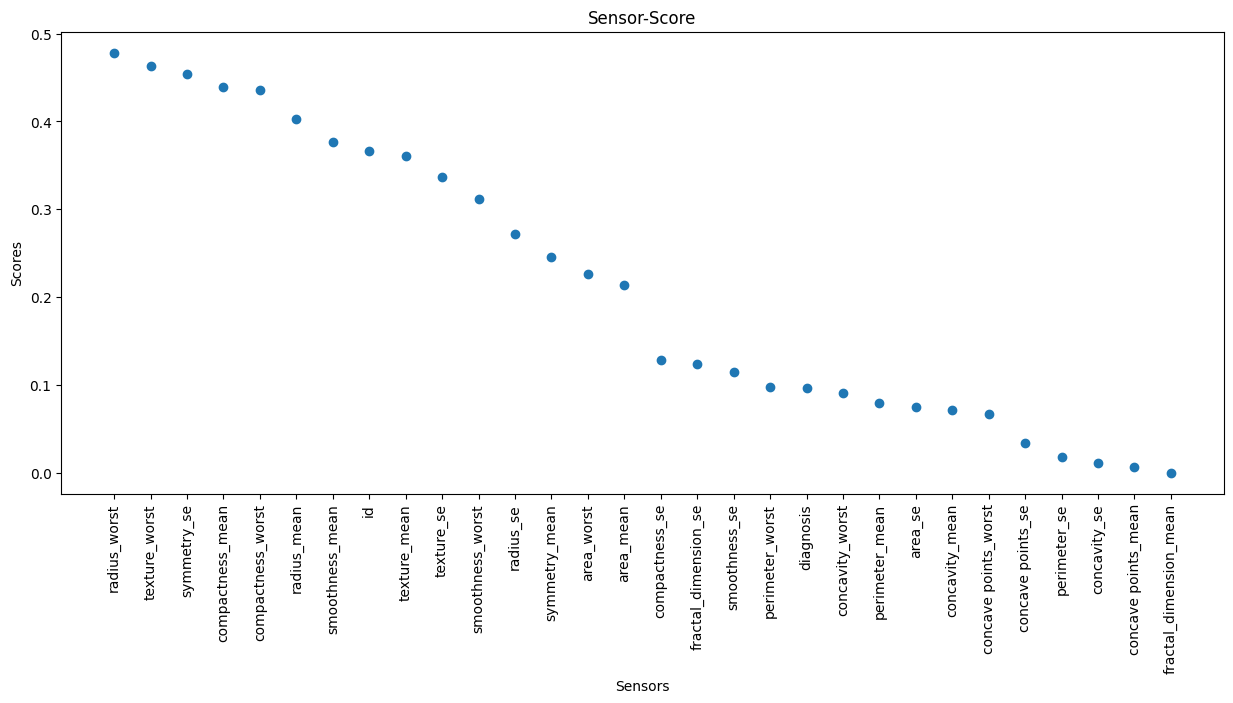

In [40]:
plotting_score(df, fit)

----------------

In [ ]:
def manual_PCA(spectrum_2D, normalization=False, cumulative=True, vals_number=20):
    """
    this function tries to correct the problem of the different outcome of the pipeline.
    the root of this problem is sklearn.decomposition.PCA. This method can have different
    outcomes if n_component has a number less than the whole amount of the eigenvalues. 
    The difference is because decomposition. PCA does not standardize your variables before doing PCA, 
    whereas in your manual computation you call StandardScaler to do the standardization.
    """
    if normalization:
        # we can centrilize our data by using .mean() 
        spectrum_2D = spectrum_2D - spectrum_2D.mean(axis=0)

        # make correlation function
        spectrum_2D = spectrum_2D / spectrum_2D.std(axis=0)
    
    # make the correlation function
    correlation = np.cov(spectrum_2D.T)

    # implement PCA
    vals, vecs = np.linalg.eigh(correlation)
    vals = vals[::-1]
    vecs = vecs[:, ::-1]

    # sketch the main plot
    fig = plt.figure(figsize=(10,20))

    # sketch the scree plot
    ax1 = fig.add_subplot(2,1,1); plt.title('Scree Plot'); plt.xlabel('Principal Component'); plt.ylabel('Eigenvalue')
    scree1 = plt.plot(np.log(vals[:vals_number]), 'o-', linewidth=2, color='k')

    # if the user wants, sketch cumulative plot
    if cumulative:
        ax2 = fig.add_subplot(2,1,2); plt.title('Cumulative Plot'); plt.xlabel('Principal Component'); plt.ylabel('Cumulative Percent')
        scree2 = plt.plot(100 * vals[:vals_number].cumsum() / sum(vals[:]), 'o-', linewidth=2, color='k')

    plt.show()
    
    return vals, vecs

def reconstruct_spectrum(spectrum_2D, vecs, component_number=15):
    """
    dimensionality reduction of the spectrum based on the number of important principle component
    """
    projections = spectrum_2D @ vecs[:, :component_number]
    inverse_projection = projections @ vecs[:, :component_number].T
    spectrum_2D = np.multiply(inverse_projection,W)

    # reshape back to 3D
    spectrum = np.reshape(spectrum_2D,(subsample_size,subsample_size,spectral_depth))

    return projections, spectrum, spectrum_2D

# sklearn library for PCA
def sklearn_PCA(spectrum_2D, vals_number=15):
    """
    # I can use the following functions to check PCA outcomes
    # pca.explained_variance_ratio_
    # pca.explained_variance_
    # pca.components_
    # pca.singular_values_
    """

    # Use PCA to reconstruct before UMAP and clustering
    # PCA part does not affect the outcome. It means that everytime that we run PCA it gives us the same results
    pca = PCA(n_components = None)
    pca.fit(spectrum_2D)

    # scree plot
    PC_values = np.arange(pca.n_components_)[:vals_number]+1
    exp_var = pca.explained_variance_ratio_[:vals_number]
    f, ax = plt.subplots(figsize=(10,10))
    ax.plot(np.log(exp_var), 'o-', linewidth=2, color='k')
    ax.set_title('Scree Plot')
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Explained Variance ')
    plt.show()

    return pca

def recunstruction_PCA_sklearn(spectrum_2D, component_number=15):
    """
    dimensionality reduction of the spectrum based on the number of important principle component
    """
    pc_keep = 15   # choose according to scree plot above (or other method)
    pca_partial = PCA(n_components=None)
    X_partial= pca_partial.fit_transform(spectrum_2D)
    #inverse transform and inverse the weight\n"
    spectrum_2D = np.multiply(pca_partial.inverse_transform(X_partial),W)

    # reshape back to 3D
    spectrum = np.reshape(spectrum_2D,(subsample_size,subsample_size,spectral_depth))
    return spectrum, spectrum_2D

def biplot(projections, vecs, pc1=0, pc2=1, vec_min=0, vec_max=10):
    """
    plot biplot to see the variation of the projection
    """
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_aspect(1)
    plt.hist2d(*projections[:, [pc1,pc2]].T, bins=2048, cmap='Spectral')
    #r = 25
    plt.xlim((-4, 2))
    #plt.ylim((-r, r))

    for i, (x,y) in enumerate(5 * vecs[vec_min:vec_max, :2]):
        plt.arrow(0, 0, x, y, color='white')
        #plt.text(1.1*x, 1.1*y, str(i//3) + 'XYZ'[i%3], color='white',
        #         horizontalalignment='center', verticalalignment='center')
    plt.show()